# Comparing _autodifferentiation_ & _finite differences_ in Metacalibration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import autometacal

In [3]:
##Local settings
import time
import os
import galsim
import tensorflow as tf

import tqdm

## Generate Data

In [4]:
seed = 31415
rng = np.random.RandomState(seed)

In [5]:
scale = 0.2
stamp_size = 51
psf_fwhm = 0.9
gal_hlr = 0.7

In [6]:
def make_data(Ngals=1,
  snr = 200,
  img_noise = 1.0e-4,
  scale = 0.2,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0], 
  flux=1.e5):
  """Simple exponetial profile toy model galaxy"""
  
  gal_list = []
  psf_list = []
 
  for n in range(Ngals):
    psf = galsim.Moffat(beta=2.5, 
                      fwhm=psf_fwhm)

    obj0 = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    noise = galsim.GaussianNoise()
    gal_image.addNoiseSNR(noise,snr=snr)
    
    gal_image = tf.convert_to_tensor(gal_image.array)
    psf_image = tf.convert_to_tensor(psf_image)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
  
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  
  return gal_image_stack, psf_image_stack

In [7]:
def make_data(Ngals=1,
              snr=2000,
  img_noise = 1.0e-4,
  scale = 0.263,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0]):

  gal_list = []
  psf_list = []

  for n in range(Ngals):
    psf = galsim.Moffat(beta=2.5, 
                      fwhm=psf_fwhm)

    obj0 = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array

    gal_image += rng.normal(scale=img_noise, size=gal_image.shape)
    gal_image = tf.convert_to_tensor(gal_image)
    psf_image = tf.convert_to_tensor(psf_image)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
    del gal_image
    del psf_image
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack 

In [8]:
gal_images, psf_images = make_data(Ngals=1,
                                  snr=2000,
                                  img_noise = 1e-4,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1 = [0.0],gal_g2=[0.0])

Text(0.5, 1.0, 'psf model')

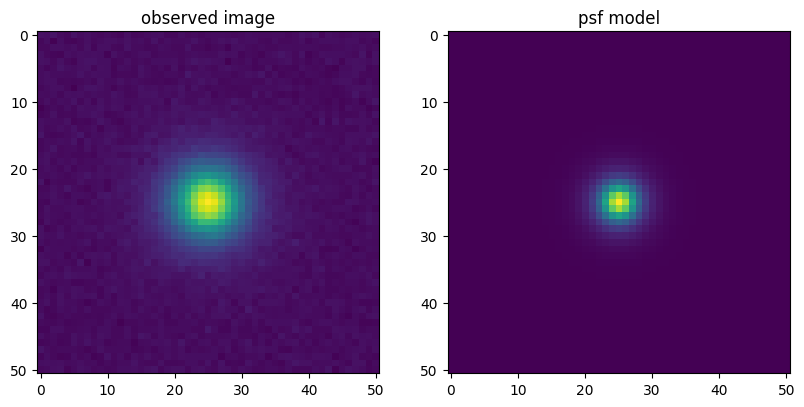

In [9]:
style.use('default')
figure(figsize=(15,5))
subplot(131)
imshow(gal_images[0]); title('observed image')
subplot(132)
imshow(psf_images[0]); title('psf model')

## Generate a 20% larger PSF for reconvolution.

In [10]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=psf_fwhm*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(
  reconv_psf.drawImage(nx=stamp_size, 
                       ny=stamp_size, 
                       scale=scale).array),axis=0)

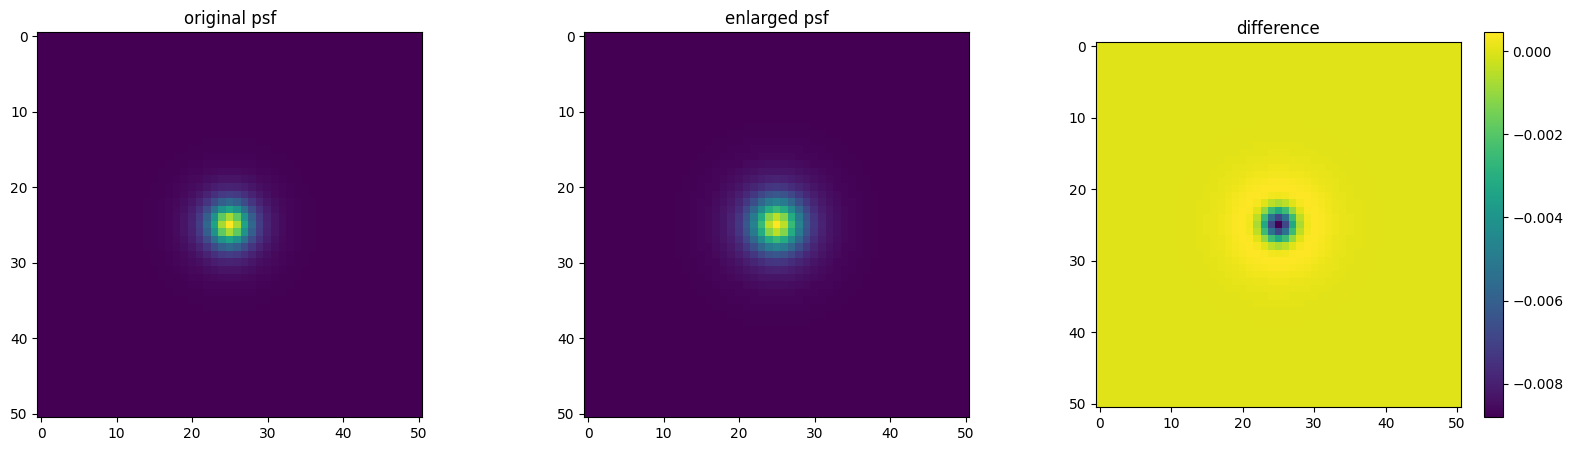

In [11]:
style.use('default')
figure(figsize=(20,5))
subplot(131)
imshow(psf_images[0]); title('original psf')
subplot(132)
imshow(reconv_psf_image[0]); title('enlarged psf')
subplot(133)
imshow(reconv_psf_image[0] - psf_images[0]); title('difference');colorbar()

## Test GalFlow Deconv/Reconv

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


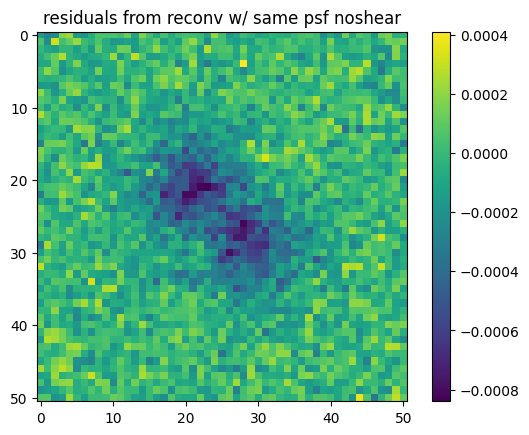

In [12]:
style.use('default')
autometacal_image = autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],[[0.0,0.0]])[0]
imshow(autometacal_image-gal_images[0]);title('residuals from reconv w/ same psf noshear');colorbar()


## GalFlow vs GalSim

In [13]:
gal_images, psf_images = make_data(Ngals=1,
                                  snr=2000,
                                  img_noise = 1e-4,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm*1.,
                                  gal_hlr = gal_hlr,
                                  gal_g1 = [0.0],gal_g2=[0.0])

In [14]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=psf_fwhm*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(
  reconv_psf.drawImage(nx=stamp_size, 
                       ny=stamp_size, 
                       scale=scale).array),axis=0)

0.994579


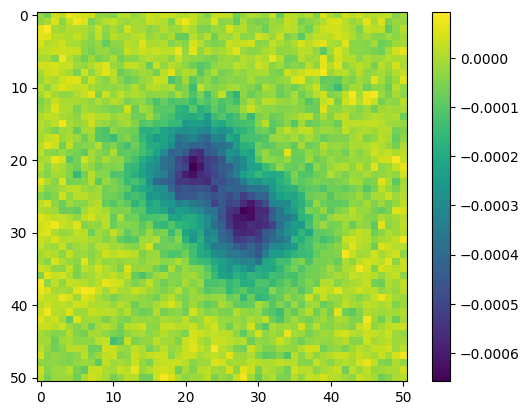

In [15]:
obj0 = galsim.Exponential(half_light_radius=gal_hlr)
counterfact = galsim.Convolve(reconv_psf,obj0)
counterfact = counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
noise = galsim.GaussianNoise(sigma=1.)
counterfact.addNoiseSNR(noise,snr=2000,preserve_flux=True)

counterfact = tf.expand_dims(tf.convert_to_tensor(counterfact.array),axis=0)
print(np.sum(counterfact))
autometacal_image =autometacal.generate_mcal_image(
  gal_images[tf.newaxis,0],
  psf_images[tf.newaxis,0],
  reconv_psf_image,
  [[0.0,0.0]]
)[0]

imshow(autometacal_image-counterfact[0]);colorbar()

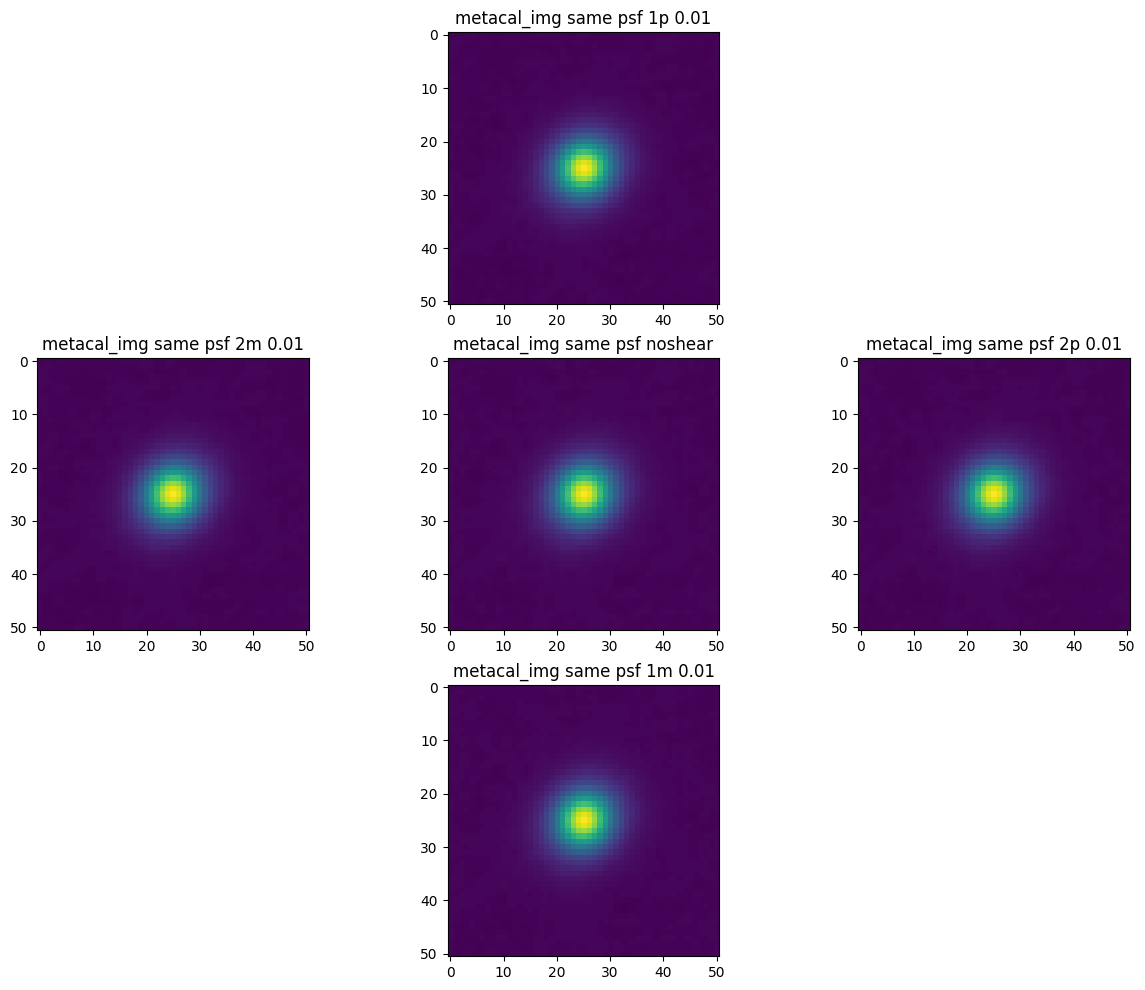

In [16]:
style.use('default')
figure(figsize=(15,12))

step = 0.01

subplot(335)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.0]])[0])
title('metacal_img same psf noshear')

subplot(332)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[step,0.0]])[0])
title(f'metacal_img same psf 1p {step}')

subplot(338)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[-step,0.0]])[0])
title(f'metacal_img same psf 1m {step}')

subplot(336)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,step]])[0])
title(f'metacal_img same psf 2p {step}')

subplot(334)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,-step]])[0])
title(f'metacal_img same psf 2m {step}')
savefig('problems1.png',bbox_inches='tight')

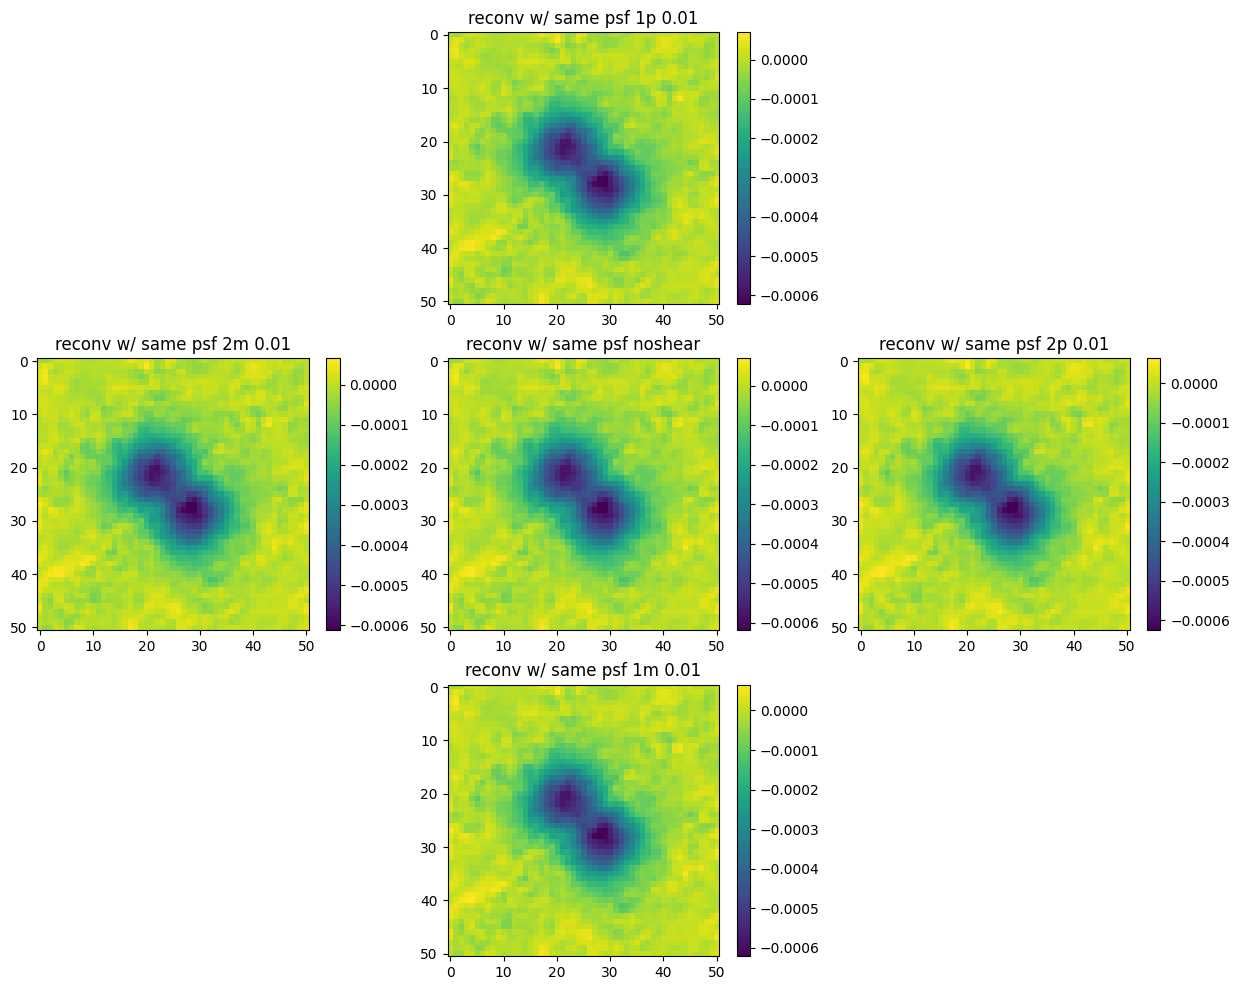

In [17]:
style.use('default')
figure(figsize=(15,12))

step = 0.01

subplot(335)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]


imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])
title('reconv w/ same psf noshear');colorbar()

subplot(332)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=step,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1p {step}');colorbar()

subplot(338)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=-step,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[-step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1m {step}');colorbar()

subplot(336)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=step)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2p {step}');colorbar()

subplot(334)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=-step)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,-step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2m {step}');colorbar()
savefig('problems2.png',bbox_inches='tight')

## Simple Ellipticity Measurements

In [18]:
def get_ellipticities(image):
  return autometacal.get_moment_ellipticities(image,0.2,4.8)

In [19]:
g = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                                      psf_images,reconv_psf_image,
                                                      [[0.0,0.0]]))
print(f'0shear  g1={g[0,0]: .4f},  g2={g[0,1]: .4f}')
print('--------------------------------')
g = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,
                                                      reconv_psf_image,
                                                      [[0.05,0.0]]))
print(f'1p .05  g1={g[0,0]: .4f},  g2={g[0,1]: .4f}')
g = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                                      psf_images,
                                                      
                                                      reconv_psf_image,[[-.05,0.0]]))
print(f'1m .05  g1={g[0,0]: .4f},  g2={g[0,1]: .4f}')
g = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                                      psf_images,
                                                      reconv_psf_image,
                                                      [[0.0,0.05]]))
print(f'2p .05  g1={g[0,0]: .4f},  g2={g[0,1]: .4f}')
g = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                                      psf_images,
                                                      reconv_psf_image,
                                                      [[0.0,-.05]]))
print(f'2m .05  g1={g[0,0]: .4f},  g2={g[0,1]: .4f}')

0shear  g1= 0.0007,  g2=-0.0504
--------------------------------
1p .05  g1= 0.0139,  g2=-0.0504
1m .05  g1=-0.0125,  g2=-0.0503
2p .05  g1= 0.0006,  g2=-0.0381
2m .05  g1= 0.0008,  g2=-0.0631


## Autodiff

In [20]:
e, R =autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities);

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f

In [21]:
for e, R in zip(e,R):
  print(e,R)

tf.Tensor([ 0.00067282 -0.05040621], shape=(2,), dtype=float32) tf.Tensor(
[[ 0.25948817 -0.00226617]
 [-0.000736    0.24792778]], shape=(2, 2), dtype=float32)


In [22]:
calibre0=tf.linalg.inv(R) @ tf.reshape(e,[2,1])
print(f'g1 = {calibre0[0,0]: .5f}, g2 = {calibre0[1,0]: .5f}')

g1 =  0.00082, g2 = -0.20331


## Single image comparison between Autodiff and Finite diff

In [23]:
e_f, R_f = autometacal.metacal.get_metacal_response_finitediff(gal_image=abs(gal_images),
                                          psf_image=psf_images,
                                          reconv_psf_image=reconv_psf_image,
                                          step=0.01,method=get_ellipticities)

for e_f, R_f in zip(e_f,R_f):
  calibre_f=tf.linalg.inv(R_f) @ tf.reshape(e_f,[2,1])
  #print(f'g1 = {calibre_f[0,0]: .5f}, g2 = {calibre_f[1,0]: .5f}')
  #print(f'e = {np.sqrt(sum(calibre_f**2)): .5f}')

## Galaxy Batches

In [24]:
from scipy.stats import truncnorm

In [25]:
def line_and_contours(lines,percentiles=[2.5,16,50,84,97.5]):
  line_and_contours = np.percentile(lines,percentiles,axis=1)
  return line_and_contours

In [26]:
g_list = []
i=0
gmax=.7
gscale = .2
gloc=0
while i<1000 :
  a, b = (-gmax - gloc) / gscale, (gmax - gloc) / gscale
  g1=g2=1
  #select ellipticities, ensure g<=1
  while g1**2+g2**2>1:
    g1 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    g2 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    i+=1
  g_list.append([g1,g2])
garray = np.array(g_list)

In [27]:
gal_images, psf_images = autometacal.datasets.galaxies.make_data(Ngals=1000,
                                  snr = 1000,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray[:,0],
                                  gal_g2=garray[:,0])

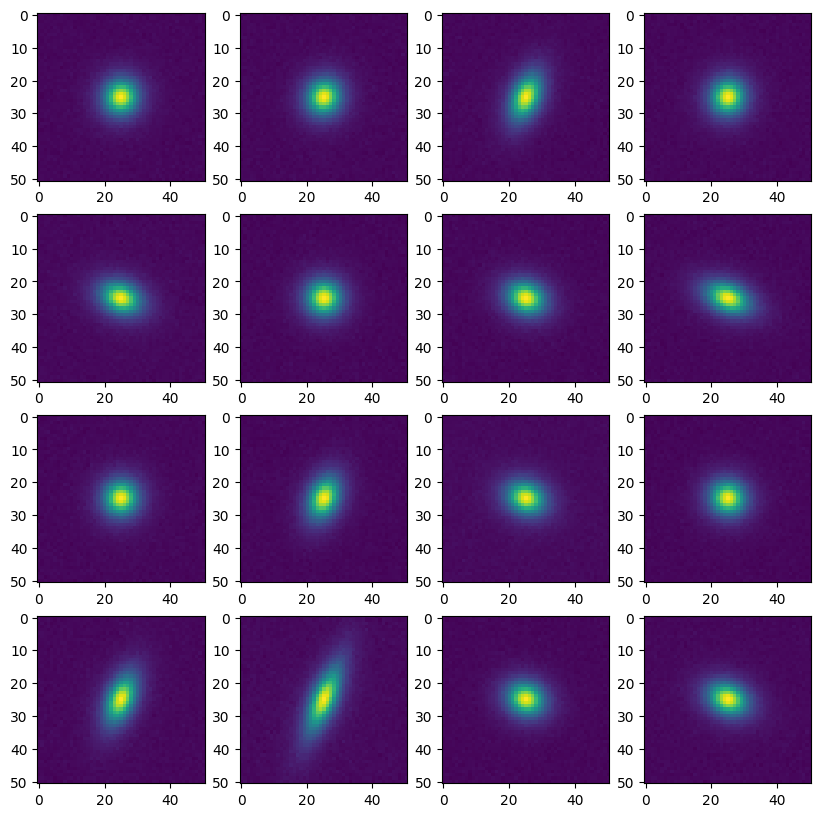

In [28]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [29]:
e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(np.mean(R_auto[:],axis=0)) @ tf.reshape(e_auto,[-1,2,1])

print(np.mean(calibre_f[:,0]),np.mean(calibre_f[:,1]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f

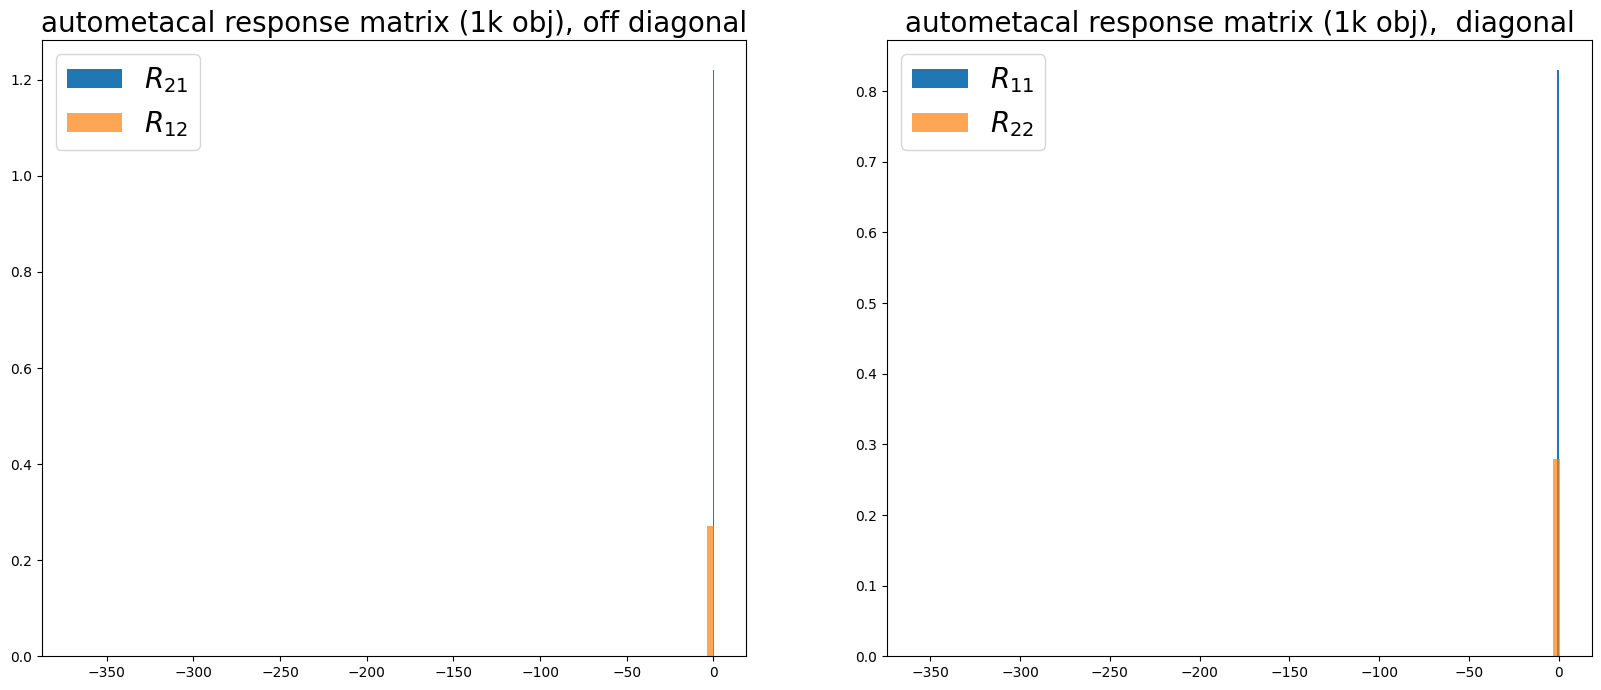

In [30]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)

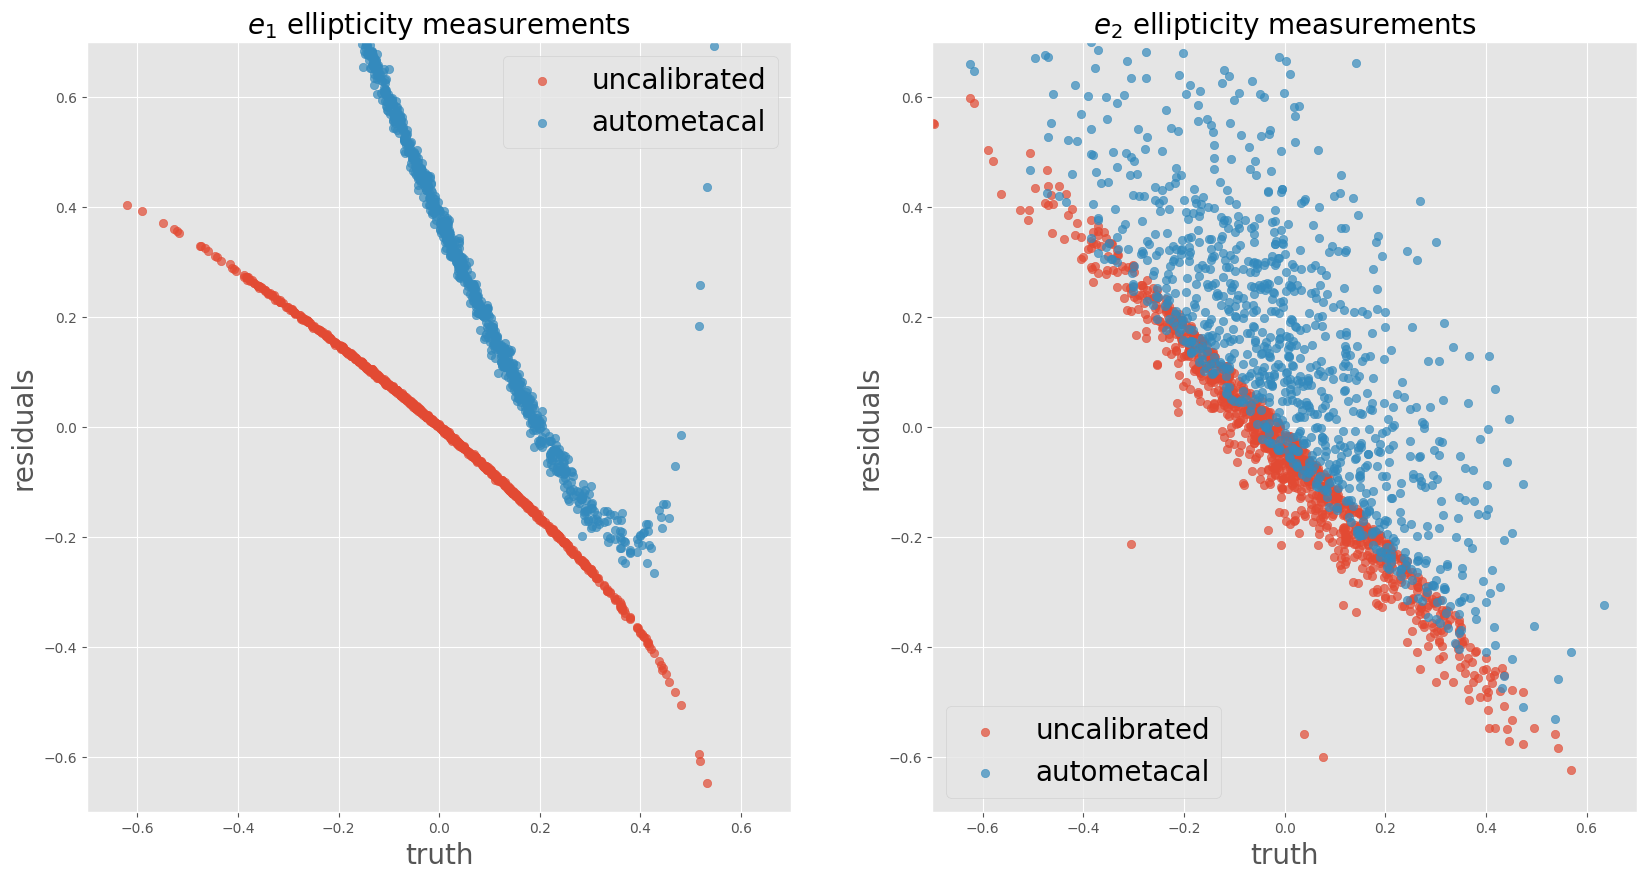

In [31]:
style.use('ggplot')
figure(figsize=(20,10))
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig("linearity.png",bbox_inches="tight")

* *This is not an École Polytechnique ad.* :-)

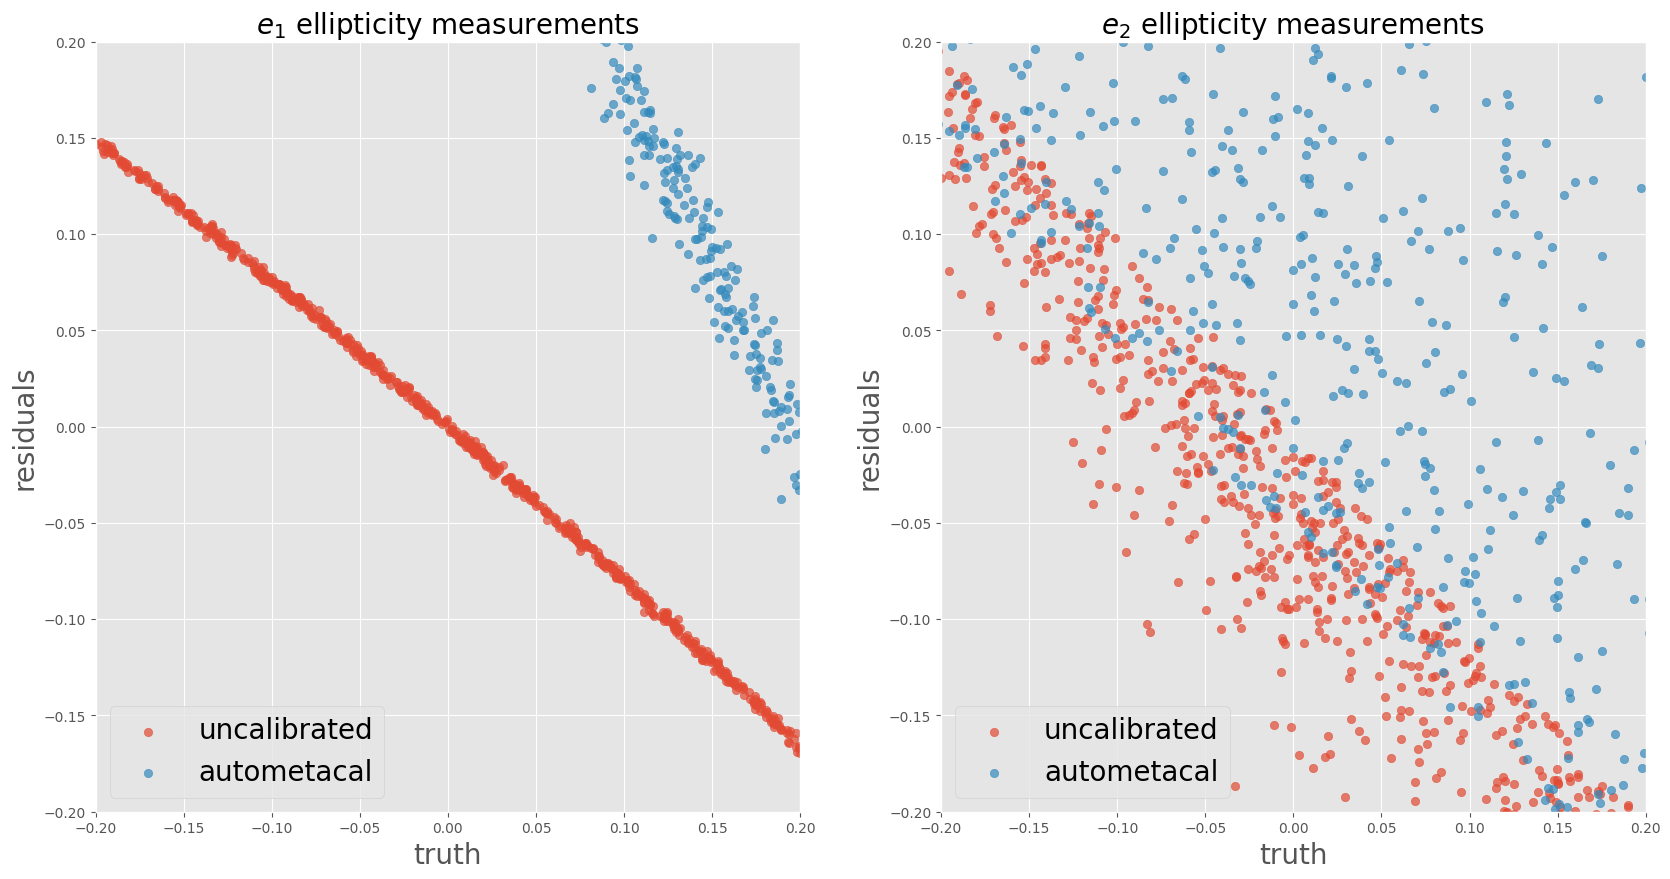

In [32]:
style.use('ggplot')
figure(figsize=(20,10))
box_size=.2
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)

subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)
savefig("linearity_zoomed.png",bbox_inches="tight")


## Averaging the response comparison over many galaxies

In [33]:
steps = logspace(-5,0,100)

In [34]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = autometacal.metacal.get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
    
R_finite=np.array(R_finite_list)    
e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f

0.010722672220103232


Text(0.5, 1.0, 'finitediff response matrix (1k obj),  diagonal')

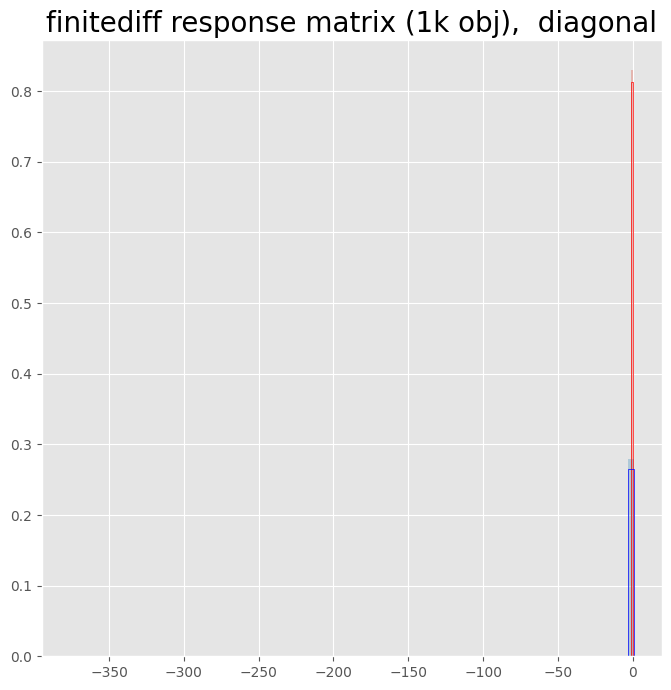

In [35]:
figure(figsize=(8,8))
subplot(111)
i =60
print(steps[i])
hist(R_finite[i,:,0,0],bins=100,density=True,histtype='step',label="$R_{11}$",alpha=1,color='red');
hist(R_finite[i,:,1,1],bins=100,density=True,histtype='step',label="$R_{22}$",alpha=1,color='blue');
hist(R_auto[:,0,0].numpy()[:],bins=100,density=True,label="$R_{11}$",alpha=.3);
hist(R_auto[:,1,1].numpy()[:],bins=100,density=True,label="$R_{22}$",alpha=.3);
title("finitediff response matrix (1k obj),  diagonal",fontsize=20)

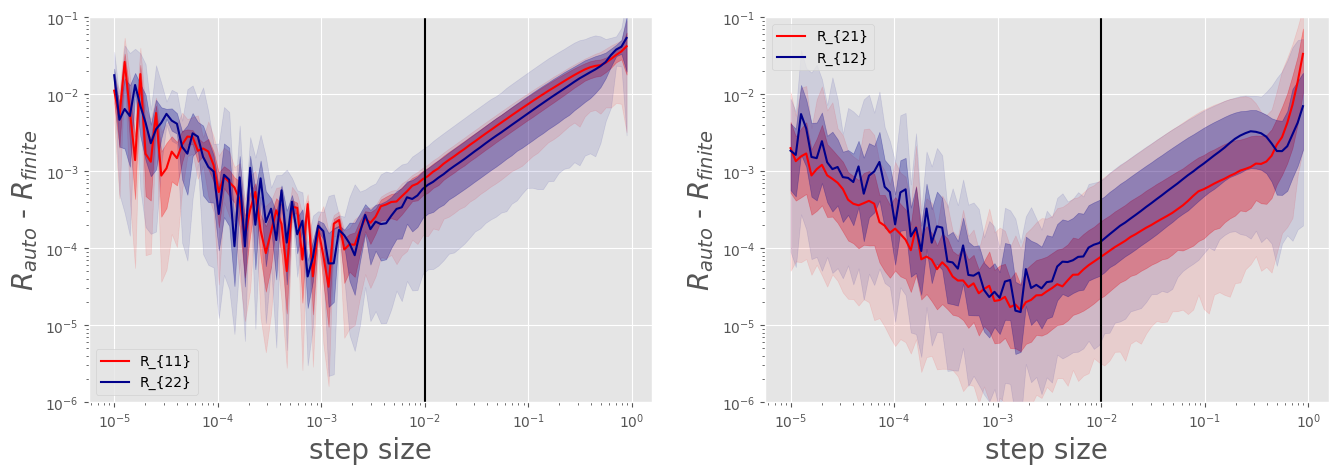

In [36]:
style.use('ggplot')
R_finite=np.array(R_finite_list)
figure(figsize=(16,5))
subplot(121)

Y00_95, Y00_84, Y00_median, Y00_16, Y00_5 = line_and_contours(abs(R_auto[:,0,0]-R_finite[:,:,0,0]))
fill_between(steps, Y00_5,Y00_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y00_16,Y00_84,color='red',alpha=0.3)####CL68
plot(steps,Y00_median,label="R_{11}",color='red')####Median 


Y11_95, Y11_84, Y11_median, Y11_16, Y11_5 = line_and_contours(abs(R_auto[:,1,1]-R_finite[:,:,1,1]))
fill_between(steps, Y11_5,Y11_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y11_16,Y11_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y11_median,label="R_{22}",color='darkblue')####Median 
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

Y10_95, Y10_84, Y10_median, Y10_16, Y10_5 = line_and_contours(abs(R_auto[:,1,0]-R_finite[:,:,1,0]))
fill_between(steps, Y10_5,Y10_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y10_16,Y10_84,color='red',alpha=0.3)####CL68
plot(steps,Y10_median,label="R_{21}",color='red')####Median 


Y01_95, Y01_84, Y01_median, Y01_16, Y01_5 = line_and_contours(abs(R_auto[:,0,1]-R_finite[:,:,0,1]))
fill_between(steps, Y01_5,Y01_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y01_16,Y01_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y01_median,label="R_{12}",color='darkblue')####Median 


plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel("$R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('median_response.png',bbox_inches='tight')

## Noisy

In [37]:
gal_images, psf_images = autometacal.datasets.galaxies.make_data(Ngals=1000,
                                  snr = 50,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

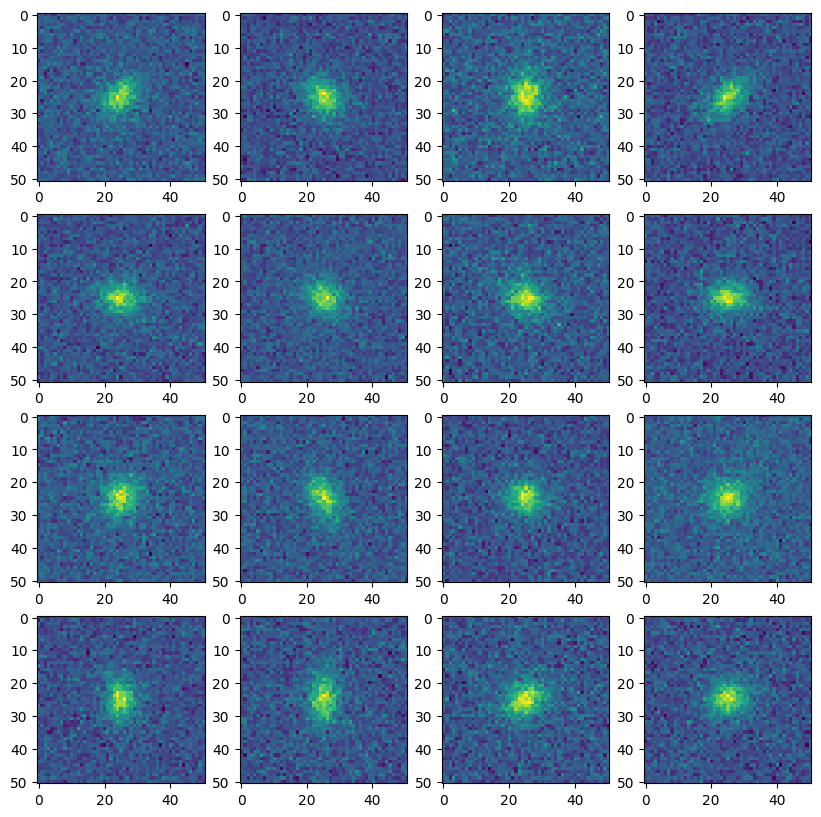

In [38]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [39]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = autometacal.metacal.get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,
                                                         method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
R_finite = np.array(R_finite_list)

e_auto, R_auto = autometacal.get_metacal_response(gal_images,
                                                  psf_images,
                                                  reconv_psf_image,
                                                  method=get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

 66%|██████▌   | 66/100 [00:55<00:28,  1.19it/s]


KeyboardInterrupt: 

In [ ]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)

In [ ]:
style.use('ggplot')
R_finite=np.array(R_finite_list)
figure(figsize=(16,5))
subplot(121)

Y00_95, Y00_84, Y00_median, Y00_16, Y00_5 = line_and_contours(abs(R_auto[:,0,0]-R_finite[:,:,0,0]))
fill_between(steps, Y00_5,Y00_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y00_16,Y00_84,color='red',alpha=0.3)####CL68
plot(steps,Y00_median,label="R_{11}",color='red')####Median 

Y11_95, Y11_84, Y11_median, Y11_16, Y11_5 = line_and_contours(abs(R_auto[:,1,1]-R_finite[:,:,1,1]))
fill_between(steps, Y11_5,Y11_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y11_16,Y11_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y11_median,label="R_{22}",color='darkblue')####Median 
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

Y10_95, Y10_84, Y10_median, Y10_16, Y10_5 = line_and_contours(abs(R_auto[:,1,0]-R_finite[:,:,1,0]))
fill_between(steps, Y10_5,Y10_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y10_16,Y10_84,color='red',alpha=0.3)####CL68
plot(steps,Y10_median,label="R_{21}",color='red')####Median 


Y01_95, Y01_84, Y01_median, Y01_16, Y01_5 = line_and_contours(abs(R_auto[:,0,1]-R_finite[:,:,0,1]))
fill_between(steps, Y01_5,Y01_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y01_16,Y01_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y01_median,label="R_{12}",color='darkblue')####Median 


plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel("$R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('median_response_20x_noise.png',bbox_inches='tight')

## Real Data

In [ ]:
import galsim
import os
import tensorflow as tf
import tqdm

In [ ]:
cat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/COSMOS_25.2_training_sample'))

In [ ]:
def make_COSMOS(Ngals, gal_size=51, psf_size=51):
  cat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/COSMOS_25.2_training_sample'))
  gal_list = []
  psf_list = []
  n=0
  list_length = 0
  while list_length < Ngals:
    gal=cat.makeGalaxy(n)
        
    if (
      (min(gal.original_gal.image.array.shape) >= gal_size) & 
      (min(gal.psf_image.array.shape) >= psf_size) 
    ):
      centre_x_gal = gal.original_gal.image.array.shape[0]//2
      centre_y_gal = gal.original_gal.image.array.shape[1]//2
      
      centre_x_psf = gal.psf_image.array.shape[0]//2
      centre_y_psf = gal.psf_image.array.shape[1]//2
      
      psf_image = tf.convert_to_tensor(gal.psf_image.array[centre_x_psf - psf_size //2 :
                                                           centre_x_psf + 1 + psf_size //2 ,
                                                           centre_y_psf - psf_size //2 :
                                                           centre_y_psf + 1 + psf_size //2 ],
                                       dtype=tf.float32)
      gal_image = tf.convert_to_tensor(gal.gal_image.array[centre_x_gal - gal_size //2 :
                                                           centre_x_gal + 1  + gal_size //2,
                                                           centre_y_gal - gal_size //2 :
                                                           centre_y_gal + 1 + gal_size //2 ],
                                       dtype=tf.float32)
      gal_list.append(gal_image)
      psf_list.append(psf_image)
      list_length += 1
      
    else:
      print(min(gal.original_gal.image.array.shape),min(gal.psf_image.array.shape),end="\r")
    n += 1
    
      
  print()
  print(n)
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [ ]:
gal_images, psf_images = make_COSMOS(1000)

In [ ]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [ ]:
def get_ellipticities(image):
  return autometacal.gaussian_moments(image,0.2,4.8)

In [ ]:
psf_fwhm = .9
scale = .2
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=psf_fwhm)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(
  reconv_psf.drawImage(nx=51, 
                       ny=51, 
                       scale=scale).array),axis=0)

In [ ]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = autometacal.metacal.get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,
                                                         method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
R_finite = np.array(R_finite_list)

e_auto, R_auto = autometacal.get_metacal_response(gal_images,
                                                  psf_images,
                                                  reconv_psf_image,
                                                  method=get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
hist(e_auto.numpy()[abs(e_auto[:,0])<1,0],bins=100);
hist(e_auto.numpy()[abs(e_auto[:,1])<1,1],bins=100);

In [ ]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[abs(e_auto[:,0])<1],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[abs(e_auto[:,0])<1],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[abs(e_auto[:,0])<1],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[abs(e_auto[:,0])<1],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_cosmos.png',bbox_inches='tight')

In [ ]:
style.use('ggplot')
R_finite=np.array(R_finite_list)
figure(figsize=(16,5))
subplot(121)

Y00_95, Y00_84, Y00_median, Y00_16, Y00_5 = line_and_contours(abs(R_auto[:,0,0]-R_finite[:,:,0,0]))
fill_between(steps, Y00_5,Y00_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y00_16,Y00_84,color='red',alpha=0.3)####CL68
plot(steps,Y00_median,label="R_{11}",color='red')####Median 

Y11_95, Y11_84, Y11_median, Y11_16, Y11_5 = line_and_contours(abs(R_auto[:,1,1]-R_finite[:,:,1,1]))
fill_between(steps, Y11_5,Y11_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y11_16,Y11_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y11_median,label="R_{22}",color='darkblue')####Median 
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

Y10_95, Y10_84, Y10_median, Y10_16, Y10_5 = line_and_contours(abs(R_auto[:,1,0]-R_finite[:,:,1,0]))
fill_between(steps, Y10_5,Y10_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y10_16,Y10_84,color='red',alpha=0.3)####CL68
plot(steps,Y10_median,label="R_{21}",color='red')####Median 


Y01_95, Y01_84, Y01_median, Y01_16, Y01_5 = line_and_contours(abs(R_auto[:,0,1]-R_finite[:,:,0,1]))
fill_between(steps, Y01_5,Y01_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y01_16,Y01_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y01_median,label="R_{12}",color='darkblue')####Median 


plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel("$R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('cosmos.png',bbox_inches='tight')

## Parametric Cosmos

HST -> CFHT

In [ ]:
import galsim
import os

In [ ]:
cat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/COSMOS_25.2_training_sample'))

In [ ]:
cat.param_cat['mag_auto']

In [ ]:
gal_ind = 142 # galaxy index

In [ ]:
pixel_scale_hst = 0.03 # HST pixel scale
pixel_scale = 0.187 # CFHT pixel scale
wcs = galsim.wcs.PixelScale(pixel_scale) #wcs: world coordinate system. Variable used to draw images in galsim
exp_time = 200 #seconds # exposure time #value corresponding to CFIS # provided by A. Guinot
sky_brightness = 21.30 #mag/arcsec^2 # for Dark sky, Moon 0%
zero_point = 10.72 #ADU/sec
cfht_eff_area = 8.022 #m^2 #effective area
qe = 0.77 # Quantum Efficiency (converts photon number to electrons)
gain = 1.62 #e-/ADU #converts electrons to ADU

In [ ]:
img_len = 51 # arbitrary value, practical because power of 2
gal = cat.makeGalaxy(gal_ind, noise_pad_size=img_len * pixel_scale_hst * np.sqrt(2))

psf = galsim.Kolmogorov(fwhm=.8,flux=1.0)#, scale_unit=galsim.arcsec) 
                                                #ommit units and let be handled withinin wcs

# shear the PSF
np.random.seed(seed=31415)

g_sigma = 0.01 # standard deviation of the shear distribution
def get_g(n_g):
    g = np.random.normal(0., g_sigma, n_g)
    while np.linalg.norm(g) > 1:
        g = np.random.normal(0., g_sigma, n_g)
    return g

e1, e2 = get_g(2) #+[cst1, cst2] because the mean of the PSF ellipticity can be different from zero
psf = psf.shear(g1=e1, g2=e2)


hst_eff_area = 2.4**2 * (1.-0.33**2)
flux_scaling = (cfht_eff_area/hst_eff_area) * exp_time * qe / gain
gal *= flux_scaling


gal = galsim.Convolve([gal, psf])

In [ ]:
gal_im = gal.drawImage(wcs=wcs, nx=img_len,ny=img_len) # Turn the galsim Galaxy object into a galsim Image object

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Convolved COSMOS Galaxy {}'.format(gal_ind))
plt.imshow(gal_im.array)
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(psf.drawImage(wcs=wcs, nx=img_len,ny=img_len).array)
plt.title(r'CFHT PSF')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [ ]:
def get_flux(ab_magnitude):
    # compared to the formula on github, we divide by the gain to convert the flux from e- to ADU
    return exp_time*zero_point*10**(-0.4*(ab_magnitude-24)) / gain


mean_sky_level = get_flux(sky_brightness) * pixel_scale ** 2
# mean_sky_level = np.sqrt(mean_sky_level_real)
print('mean_sky_level_sqrt',mean_sky_level)

sigma = np.sqrt(mean_sky_level) # we modelize the noise as a Gaussian noise such that it std
                                # is the sqrt of the Poisson parameter
print('CFHT global noise standard deviation: {:.2f}'.format(sigma))

In [ ]:
# Add noise

# Get the standard deviation value of the noise for real images
# Empirically estimate the standard deviation by considering a part of the image containing only noise
hst_std = np.std(gal_im.array[0:25,0:25])
signal = gal_im.array
hst_var = 1.4826*np.median(np.abs(signal-np.median(signal)))

print('HST noise standard deviation: {:.2f}'.format(hst_std))

delta_var = mean_sky_level - hst_var
random_seed = 24783923 #same as galsim demo 11
noise = galsim.GaussianNoise(galsim.BaseDeviate(random_seed), sigma=np.sqrt(delta_var))
# noise = galsim.PoissonNoise(rng=galsim.BaseDeviate(random_seed), sky_level=delta_var)
gal_im.addNoise(noise)
image = gal_im.array

In [ ]:
plt.figure(2, figsize=(10,10))
k=4
plt.imshow(np.arcsinh(image/(k*sigma)*k*sigma))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('ArcSinh of CFHT Image')
plt.show()
print('Standard Deviation Value of CFHT Simulated Image: {:.2f}'.format(np.std(image[0:25,0:25])))

In [ ]:
plt.figure(2, figsize=(10,10))
plt.imshow(image)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('CFHT Image')
plt.show()

In [ ]:
galsim.COSMOSCatalog?

In [ ]:
random_seed = 31415
def make_COSMOS_parametric(Ngals=1,stamp_size=51,psf_fwhm=1.,**kwargs):
  pixel_scale_hst = 0.03 # HST pixel scale
   
  ###defaults
  exp_time = 200 #seconds # exposure time #value corresponding to CFIS # provided by A. Guinot
  sky_brightness = 21.30 #mag/arcsec^2 # for Dark sky, Moon 0%
  zero_point = 10.72 #ADU/sec
  cfht_eff_area = 8.022 #m^2 #effective area
  qe = 0.77 # Quantum Efficiency (converts photon number to electrons)
  gain = 1.62 #e-/ADU #converts electrons to ADU
   
  flux = exp_time*zero_point*10**(-0.4*(sky_brightness-24)) / gain #sky flux
  mean_sky_level = flux * pixel_scale ** 2
 
  #make a simple galaxy from COSMOS catalogue
  gal_image_list = []
  psf_image_list = []
  cat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/COSMOS_23.5_training_sample'))
  dev = galsim.BaseDeviate(random_seed)
  for gal_ind in range(Ngals):
    wcs = galsim.wcs.PixelScale(pixel_scale) 
    
    gal = cat.makeGalaxy(gal_ind, noise_pad_size = stamp_size * pixel_scale_hst * np.sqrt(2))
    psf = galsim.Kolmogorov(fwhm=psf_fwhm,flux=1.0)
    gal = galsim.Convolve(gal, psf)

    #scale the flux to match CFHT
    hst_eff_area = 2.4**2 * (1.-0.33**2)
    flux_scaling = (cfht_eff_area/hst_eff_area) * exp_time * qe / gain
    gal *= flux_scaling

    # Fadi's MAD noise estimator.
    hst_var = 1.4826*np.median(np.abs(signal-np.median(signal)))

    #apply noise to the parametric image
    delta_var = mean_sky_level - hst_var
    noise = galsim.GaussianNoise(dev, sigma=np.sqrt(delta_var))


    gal_im = gal.drawImage(wcs=wcs, nx=stamp_size,ny=stamp_size)
    psf_im = psf.drawImage(nx=stamp_size,ny=stamp_size)
    gal_im.addNoise(noise)

    gal_image = gal_im.array
    psf_image = psf_im.array
    gal_image_list.append(gal_image)
    psf_image_list.append(psf_image)
    
  
  gal_images = tf.stack(gal_image_list)
  psf_images = tf.stack(psf_image_list)
 
  return gal_images, psf_images

In [ ]:
gal_images, psf_images = make_COSMOS_parametric(1000)

In [ ]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [ ]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = autometacal.metacal.get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,
                                                         method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
R_finite = np.array(R_finite_list)

e_auto, R_auto = autometacal.get_metacal_response(gal_images,
                                                  psf_images,
                                                  reconv_psf_image,
                                                  method=get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
style.use('ggplot')
R_finite=np.array(R_finite_list)
figure(figsize=(16,5))
subplot(121)

Y00_95, Y00_84, Y00_median, Y00_16, Y00_5 = line_and_contours(abs(R_auto[:,0,0]-R_finite[:,:,0,0]))
fill_between(steps, Y00_5,Y00_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y00_16,Y00_84,color='red',alpha=0.3)####CL68
plot(steps,Y00_median,label="R_{11}",color='red')####Median 

Y11_95, Y11_84, Y11_median, Y11_16, Y11_5 = line_and_contours(abs(R_auto[:,1,1]-R_finite[:,:,1,1]))
fill_between(steps, Y11_5,Y11_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y11_16,Y11_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y11_median,label="R_{22}",color='darkblue')####Median 
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

Y10_95, Y10_84, Y10_median, Y10_16, Y10_5 = line_and_contours(abs(R_auto[:,1,0]-R_finite[:,:,1,0]))
fill_between(steps, Y10_5,Y10_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y10_16,Y10_84,color='red',alpha=0.3)####CL68
plot(steps,Y10_median,label="R_{21}",color='red')####Median 


Y01_95, Y01_84, Y01_median, Y01_16, Y01_5 = line_and_contours(abs(R_auto[:,0,1]-R_finite[:,:,0,1]))
fill_between(steps, Y01_5,Y01_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y01_16,Y01_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y01_median,label="R_{12}",color='darkblue')####Median 


plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel("$R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('parametric_cosmos_cfht_very_long_exposure.png',bbox_inches='tight')